# Recommendation Systems Assignment

### MIE451/1513 UofT

### Getting MovieLens data

* Download the movielens 100k dataset from this link: [ml-100k.zip](http://files.grouplens.org/datasets/movielens/ml-100k.zip)

* Upload ml-100k.zip

* Extract using the following cell:

### Imports

In [16]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import wget
import matplotlib.pyplot as plt

## Support functions and variables

In [17]:
wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/ml-100k.zip")

'ml-100k (1).zip'

In [ ]:
!unzip ml-100k.zip

In [18]:
MOVIELENS_DIR = "ml-100k"

In [3]:
!ls {MOVIELENS_DIR}

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [19]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data

In [20]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [21]:
rating_df_train = getData(MOVIELENS_DIR, 'u1.base')
rating_df_test = getData(MOVIELENS_DIR, 'u1.test')

In [22]:
rating_df_train.head()

,userID,itemID,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [23]:
rating_df_test.head()

,userID,itemID,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [24]:
print("Number of users in rating df:", len(rating_df.userID.unique()))
print("Number of items in rating df:", len(rating_df.itemID.unique()))
print("Number of users in train df:", len(rating_df_train.userID.unique()))
print("Number of items in train df:", len(rating_df_train.itemID.unique()))
print("Number of users in test df:", len(rating_df_test.userID.unique()))
print("Number of items in test df:", len(rating_df_test.itemID.unique()))

Number of users in rating df: 943
Number of items in rating df: 1682
Number of users in train df: 943
Number of items in train df: 1650
Number of users in test df: 459
Number of items in test df: 1410


## Q1

### (a)

In [25]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT:
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items

        OUTPUT:
            matrix: 2D numpy array.

        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'

        NOTE 2: data can have more columns, but your function should ignore
              additional columns.
    """
    ########### your code goes here ###########
    matrix = np.zeros((num_users, num_items), dtype=np.int8)
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating
    ###########         end         ###########
    return matrix

In [26]:
a = dataPreprocessor(rating_df,  len(rating_df.userID.unique()),  len(rating_df.itemID.unique()))
print(a.shape)

(943, 1682)


In [27]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name

    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }

        return switcher[method_name]

    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.

            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'
        """

        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                # select the row for user
                # what's the shape of userVector
                userVector = train_matrix[user, :]

                # Extract the items the user already rated
                ratedItems = userVector[userVector.nonzero()]

                # If not empty, calculate average and set as rating for the current item
                if ratedItems.size == 0:
                    itemAvg = 0
                else:
                    itemAvg = ratedItems.mean()
                predictionMatrix[user, item] = itemAvg
        ###########         end         ###########
        return predictionMatrix

    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.

            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'
        """

        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated

        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                predictionMatrix[user, item] = itemPopularity[item]

        ###########         end         ###########
        return predictionMatrix

    def predict_all(self, train_df, num_users, num_items):

        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)

    def evaluate_test(self, test_df, copy=False):

        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df

        prediction[self.pred_column_name] = np.nan

        for (index,
             userID,
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction

    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model

    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name

    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")


In [28]:
popularity_recsys = BaseLineRecSys('popularity')

In [29]:
popularity_recsys.predict_all(rating_df_train,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))


In [30]:
x = popularity_recsys.getModel()

In [31]:
x

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.38095238, 0.37333333, ..., 0.        , 0.        ,
        0.        ],
       [0.71018277, 0.38095238, 0.37333333, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.38095238, 0.37333333, ..., 0.        , 0.        ,
        0.        ],
       [0.71018277, 0.38095238, 0.37333333, ..., 0.        , 0.        ,
        0.        ],
       [0.71018277, 0.        , 0.37333333, ..., 0.        , 0.        ,
        0.        ]])

In [32]:
np.all(x<=1)

True

In [33]:
rating_df_test.head()

,userID,itemID,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [34]:
popularity_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:00, 22494.90it/s]


,userID,itemID,rating,timestamp,popularity
0,1,6,5,887431973,0.500000
1,1,10,3,875693118,0.698630
2,1,12,5,878542960,0.872038
3,1,14,5,874965706,0.685714
4,1,17,3,875073198,0.472222


In [35]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [36]:
average_user_rating_recsys.predict_all(rating_df_train, len(rating_df.userID.unique()), len(rating_df.itemID.unique()))


In [37]:
average_user_rating_recsys.getModel()

array([[0.        , 0.        , 0.        , ..., 3.68148148, 3.68148148,
        3.68148148],
       [0.        , 3.8       , 3.8       , ..., 3.8       , 3.8       ,
        3.8       ],
       [3.        , 3.        , 3.        , ..., 3.        , 3.        ,
        3.        ],
       ...,
       [0.        , 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 0.        , 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [38]:
average_user_rating_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:00, 24232.86it/s]


,userID,itemID,rating,timestamp,useraverage
0,1,6,5,887431973,3.681481
1,1,10,3,875693118,3.681481
2,1,12,5,878542960,3.681481
3,1,14,5,874965706,3.681481
4,1,17,3,875073198,3.681481


## Q2

### (a)

In [57]:
x = dataPreprocessor(rating_df_train,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))

In [59]:
x.shape

(943, 1682)

In [75]:
len(rating_df.userID.unique()), len(rating_df.itemID.unique())

(943, 1682)

In [63]:
(1 - pairwise_distances(x.T, metric='cosine')).shape

(1682, 1682)

In [103]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name

    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }

        return switcher[method_name]

    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix

    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        ########### your code goes here ###########
        similarity_matrix = pairwise_distances(matrix, metric='euclidean')#/(2*np.max(np.linalg.norm(matrix,axis=1)))
        similarity_matrix = 1 - similarity_matrix/np.max(similarity_matrix)
        ###########         end         ###########

        return similarity_matrix

    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        ########### your code goes here ###########
        #L1 distance provides greater relative contrast of features in high dimensional data, and thus may lead to higher recommendation accuracy: https://bib.dbvis.de/uploadedFiles/155.pdf
        similarity_matrix = pairwise_distances(matrix, metric='l1')
        similarity_matrix = 1 - similarity_matrix/np.max(similarity_matrix)
        ###########         end         ###########
        return similarity_matrix

    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.model

            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)

        if self.base == 'user':
            ########### your code goes here ###########
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity = self.method(train_matrix)
            normalizer = np.matmul(uu_similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5
            self.__model = np.matmul(uu_similarity, train_matrix)/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
            # if no one has rated this item before, use user average
            useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(self.__model, axis=0)
            self.__model[:, columns==0] = self.__model[:, columns==0] + np.expand_dims(useraverage, axis=1)
            ###########         end         ###########

        elif self.base == 'item':
            ########### your code goes here ###########
            train_matrix = train_matrix.T
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            ii_similarity = self.method(train_matrix)
            normalizer = np.matmul(ii_similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5
            self.__model = np.transpose(np.matmul(ii_similarity, train_matrix)/normalizer)
            #itemaverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            #columns = np.sum(self.__model, axis=0)
            #self.__model[:, columns==0] = self.__model[:, columns==0] + np.expand_dims(itemaverage, axis=1)
            ###########         end         ###########
        else:
            print('No other option available')

    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame.
                              columns=['userID', 'itemID', 'rating', 'base-method'...]

            NOTE: 1. data can have more columns, but your function should ignore
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine',
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan

        for (index,
             userID,
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction

    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model

    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name

    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

In [40]:
# Examples of how to call similarity functions.
#I = np.eye(3)
I = np.array([[3,0,2, 3],[0,5,3, 4], [3,3,5, 1], [0,5,0, 0], [3,5,0, 3]])
print(I[[True,False, False, True, True]])

[[3 0 2 3]
 [0 5 0 0]
 [3 5 0 3]]


In [49]:
SimBasedRecSys.cosine(I)

array([[1.        , 0.54272042, 0.70710678, 0.        , 0.58523048],
       [0.54272042, 1.        , 0.72488244, 0.70710678, 0.79796252],
       [0.70710678, 0.72488244, 1.        , 0.45226702, 0.62073066],
       [0.        , 0.70710678, 0.45226702, 1.        , 0.76249285],
       [0.58523048, 0.79796252, 0.62073066, 0.76249285, 1.        ]])

In [65]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.12481005, 0.31583255, 0.        , 0.21449298],
       [0.12481005, 1.        , 0.25623156, 0.27067504, 0.36418924],
       [0.31583255, 0.25623156, 1.        , 0.08907342, 0.16206942],
       [0.        , 0.27067504, 0.08907342, 1.        , 0.38114725],
       [0.21449298, 0.36418924, 0.16206942, 0.38114725, 1.        ]])

In [66]:
SimBasedRecSys.somethingelse(I)

array([[1.        , 0.23076923, 0.38461538, 0.        , 0.46153846],
       [0.23076923, 1.        , 0.23076923, 0.46153846, 0.46153846],
       [0.38461538, 0.23076923, 1.        , 0.15384615, 0.30769231],
       [0.        , 0.46153846, 0.15384615, 1.        , 0.53846154],
       [0.46153846, 0.46153846, 0.30769231, 0.53846154, 1.        ]])

Cosine similarity works better, since it is not affected by the size of the vector. So, if a user for example has more 5 star reviews but still the same items and proportions as another user, it will still be identified as similar by the metric compared to euclidean

### (b)

L1 distance provides greater relative contrast of features in high dimensional data, and thus may lead to higher recommendation accuracy: https://bib.dbvis.de/uploadedFiles/155.pdf

##Q3

### (a)

In [67]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [68]:
user_cosine_recsys.predict_all(rating_df_train,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))


In [108]:
user_cosine_recsys.getModel()


(943, 1682)

In [70]:
rating_df_test.head()

,userID,itemID,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [71]:
user_cosine_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:00, 23823.50it/s]


,userID,itemID,rating,timestamp,user-cosine
0,1,6,5,887431973,3.419572
1,1,10,3,875693118,3.850140
2,1,12,5,878542960,4.400558
3,1,14,5,874965706,3.878056
4,1,17,3,875073198,3.130335


In [104]:
item_cosine_recsys = SimBasedRecSys('item','cosine')

In [105]:
item_cosine_recsys.predict_all(rating_df_train,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))


In [109]:
item_cosine_recsys.getModel()

array([[3.85156994, 3.7342213 , 3.83843022, ..., 4.11798149, 3.90551101,
        3.9598337 ],
       [3.87401875, 3.85300753, 3.82228493, ..., 3.77601163, 3.95744705,
        4.09365253],
       [2.96947266, 3.03381501, 2.94253433, ..., 3.12417711, 3.27065656,
        2.79578581],
       ...,
       [4.11724041, 4.06618477, 4.0274836 , ..., 4.        , 3.88126854,
        4.14874911],
       [4.37234448, 4.42355222, 4.34195687, ..., 3.95265019, 4.41470077,
        4.57717283],
       [3.52291931, 3.4890315 , 3.53459055, ..., 0.        , 3.608216  ,
        3.59916709]])

In [110]:
item_cosine_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:00, 22849.58it/s]


,userID,itemID,rating,timestamp,item-cosine
0,1,6,5,887431973,4.047083
1,1,10,3,875693118,3.976599
2,1,12,5,878542960,3.889206
3,1,14,5,874965706,4.024444
4,1,17,3,875073198,3.779897


### (b)

In [111]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)

    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }

        return switcher[metric_name]

    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame.
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))

    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame.
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)

        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions

    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame.
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls

    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))

        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value

        return matrix

    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds

    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms.
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """

        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                display(prediction.head())
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))

            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]

        results = scores

        return results


In [112]:
# How to use CrossValidation Class?

In [118]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [user_cosine_recsys, item_cosine_recsys]#[popularity_recsys,
                       #average_user_rating_recsys,
                       #user_cosine_recsys]

In [119]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, RPrecision
# Precision at K in this example
cv_patk = CrossValidation('RMSE')#P@K

In [120]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
cv_patk.run(algorithm_instances,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()),k=5)

Processing algorithm user-cosine


20000it [00:00, 23358.05it/s]


,userID,itemID,rating,timestamp,user-cosine
0,1,6,5,887431973,3.419572
1,1,10,3,875693118,3.850140
2,1,12,5,878542960,4.400558
3,1,14,5,874965706,3.878056
4,1,17,3,875073198,3.130335


20000it [00:00, 22715.03it/s]


,userID,itemID,rating,timestamp,user-cosine
0,1,1,5,874965758,3.913834
1,1,2,3,876893171,3.253514
2,1,8,1,875072484,3.980843
3,1,9,5,878543541,3.937285
4,1,21,1,878542772,2.771853


20000it [00:00, 23347.27it/s]


,userID,itemID,rating,timestamp,user-cosine
0,1,5,3,889751712,3.240668
1,1,11,2,875072262,3.893246
2,1,16,5,878543541,3.215255
3,1,25,4,875071805,3.319303
4,1,35,1,878542420,2.059214


20000it [00:00, 22258.70it/s]


,userID,itemID,rating,timestamp,user-cosine
0,1,4,3,876893119,3.627681
1,1,7,4,875071561,3.836359
2,1,42,5,876892425,3.749918
3,1,43,4,878542869,2.936146
4,1,55,5,875072688,3.719798


20000it [00:00, 23811.55it/s]


,userID,itemID,rating,timestamp,user-cosine
0,1,3,4,878542960,2.990268
1,1,13,5,875071805,3.407021
2,1,15,5,875071608,3.707102
3,1,18,4,887432020,3.107031
4,1,19,5,875071515,3.798918


Processing algorithm item-cosine


20000it [00:00, 22800.25it/s]


,userID,itemID,rating,timestamp,user-cosine,item-cosine
0,1,6,5,887431973,3.419572,4.047083
1,1,10,3,875693118,3.850140,3.976599
2,1,12,5,878542960,4.400558,3.889206
3,1,14,5,874965706,3.878056,4.024444
4,1,17,3,875073198,3.130335,3.779897


20000it [00:00, 23643.93it/s]


,userID,itemID,rating,timestamp,user-cosine,item-cosine
0,1,1,5,874965758,3.913834,3.765157
1,1,2,3,876893171,3.253514,3.680153
2,1,8,1,875072484,3.980843,3.790145
3,1,9,5,878543541,3.937285,3.845202
4,1,21,1,878542772,2.771853,3.625862


20000it [00:00, 23459.32it/s]


,userID,itemID,rating,timestamp,user-cosine,item-cosine
0,1,5,3,889751712,3.240668,3.626623
1,1,11,2,875072262,3.893246,3.710390
2,1,16,5,878543541,3.215255,3.801815
3,1,25,4,875071805,3.319303,3.707672
4,1,35,1,878542420,2.059214,3.183574


20000it [00:00, 23502.46it/s]


,userID,itemID,rating,timestamp,user-cosine,item-cosine
0,1,4,3,876893119,3.627681,3.740978
1,1,7,4,875071561,3.836359,3.768802
2,1,42,5,876892425,3.749918,3.771590
3,1,43,4,878542869,2.936146,3.595493
4,1,55,5,875072688,3.719798,3.741365


20000it [00:00, 22499.81it/s]


,userID,itemID,rating,timestamp,user-cosine,item-cosine
0,1,3,4,878542960,2.990268,3.684890
1,1,13,5,875071805,3.407021,3.848399
2,1,15,5,875071608,3.707102,3.702558
3,1,18,4,887432020,3.107031,3.877299
4,1,19,5,875071515,3.798918,4.006506


{'user-cosine': [[1.026449013124381,
   1.0214387664779507,
   1.0132940326457187,
   1.0094003999022945,
   1.0161883961525588],
  1.0173541216605808,
  1.0090130802261479,
  1.0256951630950137],
 'item-cosine': [[1.0377631264364244,
   1.0207280585350078,
   1.0101820660011795,
   1.0136832839209695,
   1.0180579656376574],
  1.0200829001062477,
  1.006824268625073,
  1.0333415315874224]}

# user-cosine
Mean: 1.017, 95% CI [1.009, 1.026]

# item-cosine
Mean: 1.020, 95% CI [1.007, 1.033]

User-user worked slightly better. This may be due to the greater personalization achievable by comparing user features, and thus can be better used to match a user's interests. There are also less users which may improve accuracy by reducing the number of contributing factors.

##Q4

(a)

## PMF

In [137]:
x = np.random.randn(3,2)
x

array([[-0.90369381, -0.4815492 ],
       [ 0.96082701, -0.35571743],
       [ 1.02170423, -0.48257159]])

In [143]:
np.sum(x[(0,0,1),:]*x[(0,0,1),:],axis=0)

array([2.55651355, 0.59031414])

In [156]:
import sys
class PMFRecSys(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        """
            num_feat: int, number of latent features
            epsilon: float, learning rate
            _lambda: float, L2 regularization,
            momentum: float, momentum of the gradient,
            maxepoch: float, Number of epoch before stop,
            num_batches: int, Number of batches in each epoch (for SGD optimization),
            batch_size:Number int, of training samples used in each batches (for SGD optimization)

        """
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors

        self.rmse_train = []
        self.rmse_test = []
        self.pred_column_name='PMF'

    def predict_all(self, train_vec, num_user, num_item):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_user: scalar. number of users
                num_item: scalar. number of items
            OUTPUT:
                no return... this method update w_User and w_Item

            NOTES:
                self.W_Item and self.W_User are use to do the final predition for a user

        """
        # select 'userID', 'itemID', 'rating only
        train_vec['userID'] = train_vec['userID']
        train_vec['itemID'] = train_vec['itemID']
        train_vec = train_vec.iloc[:, :3].values
        if self.test:
          train_vec, val_vec = train_test_split(train_vec)
          pairs_val = val_vec.shape[0]
          self.mean_rating_test = np.mean(val_vec[:, 2])
        self.mean_rating_train = np.mean(train_vec[:, 2])  # avg rating
        pairs_train = train_vec.shape[0]  # num of rating


        # to avoid out of bound
        num_user += 1
        num_item += 1
        # initialize
        self.epoch = 0
        ########### your code goes here ###########
        self.w_Item = np.random.randn(num_item, self.num_feat)
        self.w_User = np.random.randn(num_user, self.num_feat)
        ###########         end         ###########

        self.w_Item_inc = np.zeros((num_item, self.num_feat))  # accumulate the gradient
        self.w_User_inc = np.zeros((num_user, self.num_feat))  # accumulate the gradient
        while self.epoch < self.maxepoch:
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])
            np.random.shuffle(shuffled_order)  #shuffled

            # Batch update
            for batch in range(self.num_batches):
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # get the real data index


                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')


                # Compute mean rating subtracted rating
                ########### your code goes here ###########
                pred_out = np.sum(self.w_User[batch_UserID,:]*self.w_Item[batch_ItemID,:], axis=1) #size (batch_size, )
                ###########         end         ###########

                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Compute mean rating subtracted rating
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')

                    # Compute Compute mean rating subtracted rating
                    ########### your code goes here ###########
                    pred_out = np.sum(self.w_User[train_user_idx,:]*self.w_Item[train_item_idx,:], axis=1)
                    ###########         end         ###########
                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2]
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')

                    # Compute Compute mean rating subtracted rating
                    ########### your code goes here ###########
                    pred_out = np.sum(self.w_User[val_user_idx,:]*self.w_Item[val_item_idx,:], axis=1)
                    ###########         end         ###########

                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))





    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame.
                              columns=['userID', 'itemID', 'rating', 'base-method'...]

            NOTE: 1. data can have more columns, but your function should ignore
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine',
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        #prediction['userID'] = prediction['userID'] - 1
        #prediction['itemID'] = prediction['itemID'] - 1
        prediction[self.pred_column_name] = np.nan

        for (index,
             userID,
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]

        return prediction

    def plot_error(self):
      if self.test:
        plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
      plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
      plt.title('The MovieLens Dataset Learning Curve')
      plt.xlabel('Number of Epochs')
      plt.ylabel('RMSE')
      plt.legend()
      plt.grid()
      plt.show()

    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name

    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.w_Item = None
            self.w_User = None
        except:
            print("You do not have w_Item, w_User")

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            self.test = parameters.get("test_mode", False)
        else:
          raise Exception("You need to pass in a dictionary")

In [157]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 100, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})

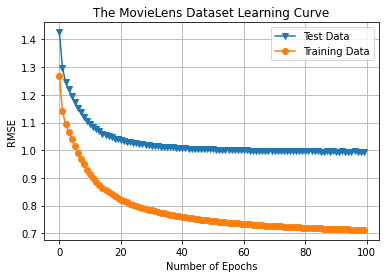

In [158]:
pmf.predict_all(rating_df,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))
pmf.plot_error()

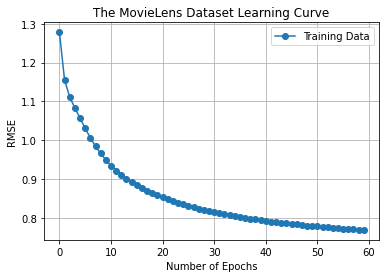

In [159]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 60, "num_batches": 100,
                "batch_size": 1000, 'test_mode':False})
pmf.predict_all(rating_df,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))
pmf.plot_error()

##Q5

### (a)

In [162]:
algorithm_instances = [popularity_recsys,
                       average_user_rating_recsys,
                       user_cosine_recsys,
                       item_cosine_recsys,
                       pmf]
metrics = {k:CrossValidation(k) for k in ('RMSE', 'P@K', 'R@K')}
for metric, cv in metrics.items():
    print(metric)
    print(cv.run(algorithm_instances,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()),k=5))

RMSE
Processing algorithm popularity


20000it [00:00, 23306.45it/s]


,userID,itemID,rating,timestamp,popularity
0,1,6,5,887431973,0.500000
1,1,10,3,875693118,0.698630
2,1,12,5,878542960,0.872038
3,1,14,5,874965706,0.685714
4,1,17,3,875073198,0.472222


20000it [00:00, 22538.61it/s]


,userID,itemID,rating,timestamp,popularity
0,1,1,5,874965758,0.717877
1,1,2,3,876893171,0.401869
2,1,8,1,875072484,0.691429
3,1,9,5,878543541,0.698795
4,1,21,1,878542772,0.206349


20000it [00:00, 22736.94it/s]


,userID,itemID,rating,timestamp,popularity
0,1,5,3,889751712,0.454545
1,1,11,2,875072262,0.717277
2,1,16,5,878543541,0.413793
3,1,25,4,875071805,0.497908
4,1,35,1,878542420,0.222222


20000it [00:00, 22289.81it/s]


,userID,itemID,rating,timestamp,popularity
0,1,4,3,876893119,0.630303
1,1,7,4,875071561,0.671975
2,1,42,5,876892425,0.632000
3,1,43,4,878542869,0.200000
4,1,55,5,875072688,0.647619


20000it [00:00, 23341.56it/s]


,userID,itemID,rating,timestamp,popularity
0,1,3,4,878542960,0.342466
1,1,13,5,875071805,0.496732
2,1,15,5,875071608,0.627049
3,1,18,4,887432020,0.250000
4,1,19,5,875071515,0.705882


Processing algorithm useraverage


20000it [00:00, 22479.80it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,6,5,887431973,0.500000,3.681481
1,1,10,3,875693118,0.698630,3.681481
2,1,12,5,878542960,0.872038,3.681481
3,1,14,5,874965706,0.685714,3.681481
4,1,17,3,875073198,0.472222,3.681481


20000it [00:00, 22309.77it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,1,5,874965758,0.717877,3.633028
1,1,2,3,876893171,0.401869,3.633028
2,1,8,1,875072484,0.691429,3.633028
3,1,9,5,878543541,0.698795,3.633028
4,1,21,1,878542772,0.206349,3.633028


20000it [00:00, 22553.03it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,5,3,889751712,0.454545,3.575107
1,1,11,2,875072262,0.717277,3.575107
2,1,16,5,878543541,0.413793,3.575107
3,1,25,4,875071805,0.497908,3.575107
4,1,35,1,878542420,0.222222,3.575107


20000it [00:00, 22381.81it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,4,3,876893119,0.630303,3.59761
1,1,7,4,875071561,0.671975,3.59761
2,1,42,5,876892425,0.632000,3.59761
3,1,43,4,878542869,0.200000,3.59761
4,1,55,5,875072688,0.647619,3.59761


20000it [00:00, 21853.87it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,3,4,878542960,0.342466,3.59761
1,1,13,5,875071805,0.496732,3.59761
2,1,15,5,875071608,0.627049,3.59761
3,1,18,4,887432020,0.250000,3.59761
4,1,19,5,875071515,0.705882,3.59761


Processing algorithm user-cosine


20000it [00:00, 21551.85it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,6,5,887431973,0.500000,3.681481,3.419572
1,1,10,3,875693118,0.698630,3.681481,3.850140
2,1,12,5,878542960,0.872038,3.681481,4.400558
3,1,14,5,874965706,0.685714,3.681481,3.878056
4,1,17,3,875073198,0.472222,3.681481,3.130335


20000it [00:00, 22025.21it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,1,5,874965758,0.717877,3.633028,3.913834
1,1,2,3,876893171,0.401869,3.633028,3.253514
2,1,8,1,875072484,0.691429,3.633028,3.980843
3,1,9,5,878543541,0.698795,3.633028,3.937285
4,1,21,1,878542772,0.206349,3.633028,2.771853


20000it [00:00, 21179.32it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,5,3,889751712,0.454545,3.575107,3.240668
1,1,11,2,875072262,0.717277,3.575107,3.893246
2,1,16,5,878543541,0.413793,3.575107,3.215255
3,1,25,4,875071805,0.497908,3.575107,3.319303
4,1,35,1,878542420,0.222222,3.575107,2.059214


20000it [00:00, 21686.59it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,4,3,876893119,0.630303,3.59761,3.627681
1,1,7,4,875071561,0.671975,3.59761,3.836359
2,1,42,5,876892425,0.632000,3.59761,3.749918
3,1,43,4,878542869,0.200000,3.59761,2.936146
4,1,55,5,875072688,0.647619,3.59761,3.719798


20000it [00:00, 22198.78it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,3,4,878542960,0.342466,3.59761,2.990268
1,1,13,5,875071805,0.496732,3.59761,3.407021
2,1,15,5,875071608,0.627049,3.59761,3.707102
3,1,18,4,887432020,0.250000,3.59761,3.107031
4,1,19,5,875071515,0.705882,3.59761,3.798918


Processing algorithm item-cosine


20000it [00:00, 20863.80it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,6,5,887431973,0.500000,3.681481,3.419572,4.047083
1,1,10,3,875693118,0.698630,3.681481,3.850140,3.976599
2,1,12,5,878542960,0.872038,3.681481,4.400558,3.889206
3,1,14,5,874965706,0.685714,3.681481,3.878056,4.024444
4,1,17,3,875073198,0.472222,3.681481,3.130335,3.779897


20000it [00:00, 21968.44it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,1,5,874965758,0.717877,3.633028,3.913834,3.765157
1,1,2,3,876893171,0.401869,3.633028,3.253514,3.680153
2,1,8,1,875072484,0.691429,3.633028,3.980843,3.790145
3,1,9,5,878543541,0.698795,3.633028,3.937285,3.845202
4,1,21,1,878542772,0.206349,3.633028,2.771853,3.625862


20000it [00:01, 19333.52it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,5,3,889751712,0.454545,3.575107,3.240668,3.626623
1,1,11,2,875072262,0.717277,3.575107,3.893246,3.710390
2,1,16,5,878543541,0.413793,3.575107,3.215255,3.801815
3,1,25,4,875071805,0.497908,3.575107,3.319303,3.707672
4,1,35,1,878542420,0.222222,3.575107,2.059214,3.183574


20000it [00:00, 20868.25it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,4,3,876893119,0.630303,3.59761,3.627681,3.740978
1,1,7,4,875071561,0.671975,3.59761,3.836359,3.768802
2,1,42,5,876892425,0.632000,3.59761,3.749918,3.771590
3,1,43,4,878542869,0.200000,3.59761,2.936146,3.595493
4,1,55,5,875072688,0.647619,3.59761,3.719798,3.741365


20000it [00:00, 22137.46it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,3,4,878542960,0.342466,3.59761,2.990268,3.684890
1,1,13,5,875071805,0.496732,3.59761,3.407021,3.848399
2,1,15,5,875071608,0.627049,3.59761,3.707102,3.702558
3,1,18,4,887432020,0.250000,3.59761,3.107031,3.877299
4,1,19,5,875071515,0.705882,3.59761,3.798918,4.006506


Processing algorithm PMF


20000it [00:01, 17029.09it/s]


,userID,itemID,rating,PMF
0,1,6,5,3.920511
1,1,10,3,3.613047
2,1,12,5,4.601069
3,1,14,5,4.398049
4,1,17,3,3.676142


20000it [00:01, 17502.91it/s]


,userID,itemID,rating,PMF
0,1,1,5,3.901093
1,1,2,3,3.072709
2,1,8,1,4.045024
3,1,9,5,4.305022
4,1,21,1,2.389863


20000it [00:01, 17299.04it/s]


,userID,itemID,rating,PMF
0,1,5,3,2.859060
1,1,11,2,4.071520
2,1,16,5,4.261443
3,1,25,4,3.342545
4,1,35,1,2.271856


20000it [00:01, 17778.34it/s]


,userID,itemID,rating,PMF
0,1,4,3,3.992439
1,1,7,4,4.331316
2,1,42,5,3.664976
3,1,43,4,3.076669
4,1,55,5,3.959884


20000it [00:01, 17693.91it/s]


,userID,itemID,rating,PMF
0,1,3,4,2.761179
1,1,13,5,3.533072
2,1,15,5,3.478136
3,1,18,4,3.317754
4,1,19,5,3.781958


{'popularity': [[3.177941281084362, 3.1750480150769977, 3.147474655005899, 3.146164503024159, 3.1488360007536382], 3.1590928909890112, 3.139292746995387, 3.1788930349826354], 'useraverage': [[1.0629951276561334, 1.0467467492319966, 1.0328964562995389, 1.0366575971298078, 1.0392923504800367], 1.0437176561595025, 1.0289303496379316, 1.0585049626810734], 'user-cosine': [[1.026449013124381, 1.0214387664779507, 1.0132940326457187, 1.0094003999022945, 1.0161883961525588], 1.0173541216605808, 1.0090130802261479, 1.0256951630950137], 'item-cosine': [[1.0377631264364244, 1.0207280585350078, 1.0101820660011795, 1.0136832839209695, 1.0180579656376574], 1.0200829001062477, 1.006824268625073, 1.0333415315874224], 'PMF': [[1.0180642981452317, 0.9941640115629037, 0.985332914579424, 0.979798252543025, 1.0017322670360025], 0.9958183487733173, 0.9772018615895515, 1.0144348359570832]}
P@K
Processing algorithm popularity


20000it [00:00, 22517.46it/s]


,userID,itemID,rating,timestamp,popularity
0,1,6,5,887431973,0.500000
1,1,10,3,875693118,0.698630
2,1,12,5,878542960,0.872038
3,1,14,5,874965706,0.685714
4,1,17,3,875073198,0.472222


20000it [00:00, 21997.54it/s]


,userID,itemID,rating,timestamp,popularity
0,1,1,5,874965758,0.717877
1,1,2,3,876893171,0.401869
2,1,8,1,875072484,0.691429
3,1,9,5,878543541,0.698795
4,1,21,1,878542772,0.206349


20000it [00:00, 21959.26it/s]


,userID,itemID,rating,timestamp,popularity
0,1,5,3,889751712,0.454545
1,1,11,2,875072262,0.717277
2,1,16,5,878543541,0.413793
3,1,25,4,875071805,0.497908
4,1,35,1,878542420,0.222222


20000it [00:00, 21993.02it/s]


,userID,itemID,rating,timestamp,popularity
0,1,4,3,876893119,0.630303
1,1,7,4,875071561,0.671975
2,1,42,5,876892425,0.632000
3,1,43,4,878542869,0.200000
4,1,55,5,875072688,0.647619


20000it [00:00, 22725.23it/s]


,userID,itemID,rating,timestamp,popularity
0,1,3,4,878542960,0.342466
1,1,13,5,875071805,0.496732
2,1,15,5,875071608,0.627049
3,1,18,4,887432020,0.250000
4,1,19,5,875071515,0.705882


Processing algorithm useraverage


20000it [00:00, 22986.28it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,6,5,887431973,0.500000,3.681481
1,1,10,3,875693118,0.698630,3.681481
2,1,12,5,878542960,0.872038,3.681481
3,1,14,5,874965706,0.685714,3.681481
4,1,17,3,875073198,0.472222,3.681481


20000it [00:00, 22096.50it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,1,5,874965758,0.717877,3.633028
1,1,2,3,876893171,0.401869,3.633028
2,1,8,1,875072484,0.691429,3.633028
3,1,9,5,878543541,0.698795,3.633028
4,1,21,1,878542772,0.206349,3.633028


20000it [00:00, 22421.68it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,5,3,889751712,0.454545,3.575107
1,1,11,2,875072262,0.717277,3.575107
2,1,16,5,878543541,0.413793,3.575107
3,1,25,4,875071805,0.497908,3.575107
4,1,35,1,878542420,0.222222,3.575107


20000it [00:00, 22149.26it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,4,3,876893119,0.630303,3.59761
1,1,7,4,875071561,0.671975,3.59761
2,1,42,5,876892425,0.632000,3.59761
3,1,43,4,878542869,0.200000,3.59761
4,1,55,5,875072688,0.647619,3.59761


20000it [00:00, 22897.62it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,3,4,878542960,0.342466,3.59761
1,1,13,5,875071805,0.496732,3.59761
2,1,15,5,875071608,0.627049,3.59761
3,1,18,4,887432020,0.250000,3.59761
4,1,19,5,875071515,0.705882,3.59761


Processing algorithm user-cosine


20000it [00:00, 20973.21it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,6,5,887431973,0.500000,3.681481,3.419572
1,1,10,3,875693118,0.698630,3.681481,3.850140
2,1,12,5,878542960,0.872038,3.681481,4.400558
3,1,14,5,874965706,0.685714,3.681481,3.878056
4,1,17,3,875073198,0.472222,3.681481,3.130335


20000it [00:00, 21662.66it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,1,5,874965758,0.717877,3.633028,3.913834
1,1,2,3,876893171,0.401869,3.633028,3.253514
2,1,8,1,875072484,0.691429,3.633028,3.980843
3,1,9,5,878543541,0.698795,3.633028,3.937285
4,1,21,1,878542772,0.206349,3.633028,2.771853


20000it [00:00, 21346.91it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,5,3,889751712,0.454545,3.575107,3.240668
1,1,11,2,875072262,0.717277,3.575107,3.893246
2,1,16,5,878543541,0.413793,3.575107,3.215255
3,1,25,4,875071805,0.497908,3.575107,3.319303
4,1,35,1,878542420,0.222222,3.575107,2.059214


20000it [00:00, 22066.38it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,4,3,876893119,0.630303,3.59761,3.627681
1,1,7,4,875071561,0.671975,3.59761,3.836359
2,1,42,5,876892425,0.632000,3.59761,3.749918
3,1,43,4,878542869,0.200000,3.59761,2.936146
4,1,55,5,875072688,0.647619,3.59761,3.719798


20000it [00:00, 21514.25it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,3,4,878542960,0.342466,3.59761,2.990268
1,1,13,5,875071805,0.496732,3.59761,3.407021
2,1,15,5,875071608,0.627049,3.59761,3.707102
3,1,18,4,887432020,0.250000,3.59761,3.107031
4,1,19,5,875071515,0.705882,3.59761,3.798918


Processing algorithm item-cosine


20000it [00:00, 21090.94it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,6,5,887431973,0.500000,3.681481,3.419572,4.047083
1,1,10,3,875693118,0.698630,3.681481,3.850140,3.976599
2,1,12,5,878542960,0.872038,3.681481,4.400558,3.889206
3,1,14,5,874965706,0.685714,3.681481,3.878056,4.024444
4,1,17,3,875073198,0.472222,3.681481,3.130335,3.779897


20000it [00:00, 21868.61it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,1,5,874965758,0.717877,3.633028,3.913834,3.765157
1,1,2,3,876893171,0.401869,3.633028,3.253514,3.680153
2,1,8,1,875072484,0.691429,3.633028,3.980843,3.790145
3,1,9,5,878543541,0.698795,3.633028,3.937285,3.845202
4,1,21,1,878542772,0.206349,3.633028,2.771853,3.625862


20000it [00:00, 22177.75it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,5,3,889751712,0.454545,3.575107,3.240668,3.626623
1,1,11,2,875072262,0.717277,3.575107,3.893246,3.710390
2,1,16,5,878543541,0.413793,3.575107,3.215255,3.801815
3,1,25,4,875071805,0.497908,3.575107,3.319303,3.707672
4,1,35,1,878542420,0.222222,3.575107,2.059214,3.183574


20000it [00:00, 21324.39it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,4,3,876893119,0.630303,3.59761,3.627681,3.740978
1,1,7,4,875071561,0.671975,3.59761,3.836359,3.768802
2,1,42,5,876892425,0.632000,3.59761,3.749918,3.771590
3,1,43,4,878542869,0.200000,3.59761,2.936146,3.595493
4,1,55,5,875072688,0.647619,3.59761,3.719798,3.741365


20000it [00:00, 21420.72it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,3,4,878542960,0.342466,3.59761,2.990268,3.684890
1,1,13,5,875071805,0.496732,3.59761,3.407021,3.848399
2,1,15,5,875071608,0.627049,3.59761,3.707102,3.702558
3,1,18,4,887432020,0.250000,3.59761,3.107031,3.877299
4,1,19,5,875071515,0.705882,3.59761,3.798918,4.006506


Processing algorithm PMF


20000it [00:01, 17476.47it/s]


,userID,itemID,rating,PMF
0,1,6,5,4.303957
1,1,10,3,3.485017
2,1,12,5,4.439174
3,1,14,5,4.144356
4,1,17,3,3.073738


20000it [00:01, 17583.31it/s]


,userID,itemID,rating,PMF
0,1,1,5,4.023412
1,1,2,3,3.397310
2,1,8,1,4.316043
3,1,9,5,4.204634
4,1,21,1,1.728927


20000it [00:01, 18055.03it/s]


,userID,itemID,rating,PMF
0,1,5,3,2.730863
1,1,11,2,4.248599
2,1,16,5,4.060104
3,1,25,4,3.294116
4,1,35,1,0.328909


20000it [00:01, 17646.95it/s]


,userID,itemID,rating,PMF
0,1,4,3,4.033140
1,1,7,4,4.023777
2,1,42,5,3.643005
3,1,43,4,2.779764
4,1,55,5,3.951254


20000it [00:01, 17597.49it/s]


,userID,itemID,rating,PMF
0,1,3,4,3.009438
1,1,13,5,3.253637
2,1,15,5,3.559950
3,1,18,4,2.711202
4,1,19,5,4.105576


{'popularity': [[0.36924708377518656, 0.4965005302226948, 0.6152704135737019, 0.6426299045599162, 0.6292682926829279], 0.5505832449628855, 0.40544114481568705, 0.6957253451100839], 'useraverage': [[0.30604453870625714, 0.4305408271474029, 0.5321314952279973, 0.5520678685047737, 0.5474019088016986], 0.4736373276776259, 0.3419993013451059, 0.6052753540101459], 'user-cosine': [[0.37179215270413657, 0.503923647932133, 0.621633085896077, 0.6483563096500541, 0.6335100742311777], 0.5558430540827157, 0.40959849499983714, 0.7020876131655943], 'item-cosine': [[0.34316012725344736, 0.483563096500532, 0.6021208907741271, 0.6248144220572649, 0.6074231177094392], 0.5322163308589621, 0.3837005215009889, 0.6807321402169354], 'PMF': [[0.353340402969248, 0.4911983032873819, 0.6086956521739146, 0.6296924708377529, 0.608695652173914], 0.5383244962884423, 0.3931343368384468, 0.6835146557384377]}
R@K
Processing algorithm popularity


20000it [00:00, 21913.44it/s]


,userID,itemID,rating,timestamp,popularity
0,1,6,5,887431973,0.500000
1,1,10,3,875693118,0.698630
2,1,12,5,878542960,0.872038
3,1,14,5,874965706,0.685714
4,1,17,3,875073198,0.472222


20000it [00:00, 21205.19it/s]


,userID,itemID,rating,timestamp,popularity
0,1,1,5,874965758,0.717877
1,1,2,3,876893171,0.401869
2,1,8,1,875072484,0.691429
3,1,9,5,878543541,0.698795
4,1,21,1,878542772,0.206349


20000it [00:00, 21023.90it/s]


,userID,itemID,rating,timestamp,popularity
0,1,5,3,889751712,0.454545
1,1,11,2,875072262,0.717277
2,1,16,5,878543541,0.413793
3,1,25,4,875071805,0.497908
4,1,35,1,878542420,0.222222


20000it [00:00, 22435.15it/s]


,userID,itemID,rating,timestamp,popularity
0,1,4,3,876893119,0.630303
1,1,7,4,875071561,0.671975
2,1,42,5,876892425,0.632000
3,1,43,4,878542869,0.200000
4,1,55,5,875072688,0.647619


20000it [00:00, 22920.19it/s]


,userID,itemID,rating,timestamp,popularity
0,1,3,4,878542960,0.342466
1,1,13,5,875071805,0.496732
2,1,15,5,875071608,0.627049
3,1,18,4,887432020,0.250000
4,1,19,5,875071515,0.705882


Processing algorithm useraverage


20000it [00:00, 23165.14it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,6,5,887431973,0.500000,3.681481
1,1,10,3,875693118,0.698630,3.681481
2,1,12,5,878542960,0.872038,3.681481
3,1,14,5,874965706,0.685714,3.681481
4,1,17,3,875073198,0.472222,3.681481


20000it [00:00, 22280.59it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,1,5,874965758,0.717877,3.633028
1,1,2,3,876893171,0.401869,3.633028
2,1,8,1,875072484,0.691429,3.633028
3,1,9,5,878543541,0.698795,3.633028
4,1,21,1,878542772,0.206349,3.633028


20000it [00:00, 21975.93it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,5,3,889751712,0.454545,3.575107
1,1,11,2,875072262,0.717277,3.575107
2,1,16,5,878543541,0.413793,3.575107
3,1,25,4,875071805,0.497908,3.575107
4,1,35,1,878542420,0.222222,3.575107


20000it [00:00, 22357.22it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,4,3,876893119,0.630303,3.59761
1,1,7,4,875071561,0.671975,3.59761
2,1,42,5,876892425,0.632000,3.59761
3,1,43,4,878542869,0.200000,3.59761
4,1,55,5,875072688,0.647619,3.59761


20000it [00:00, 22424.92it/s]


,userID,itemID,rating,timestamp,popularity,useraverage
0,1,3,4,878542960,0.342466,3.59761
1,1,13,5,875071805,0.496732,3.59761
2,1,15,5,875071608,0.627049,3.59761
3,1,18,4,887432020,0.250000,3.59761
4,1,19,5,875071515,0.705882,3.59761


Processing algorithm user-cosine


20000it [00:00, 21864.62it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,6,5,887431973,0.500000,3.681481,3.419572
1,1,10,3,875693118,0.698630,3.681481,3.850140
2,1,12,5,878542960,0.872038,3.681481,4.400558
3,1,14,5,874965706,0.685714,3.681481,3.878056
4,1,17,3,875073198,0.472222,3.681481,3.130335


20000it [00:00, 20333.86it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,1,5,874965758,0.717877,3.633028,3.913834
1,1,2,3,876893171,0.401869,3.633028,3.253514
2,1,8,1,875072484,0.691429,3.633028,3.980843
3,1,9,5,878543541,0.698795,3.633028,3.937285
4,1,21,1,878542772,0.206349,3.633028,2.771853


20000it [00:00, 21344.85it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,5,3,889751712,0.454545,3.575107,3.240668
1,1,11,2,875072262,0.717277,3.575107,3.893246
2,1,16,5,878543541,0.413793,3.575107,3.215255
3,1,25,4,875071805,0.497908,3.575107,3.319303
4,1,35,1,878542420,0.222222,3.575107,2.059214


20000it [00:00, 21173.48it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,4,3,876893119,0.630303,3.59761,3.627681
1,1,7,4,875071561,0.671975,3.59761,3.836359
2,1,42,5,876892425,0.632000,3.59761,3.749918
3,1,43,4,878542869,0.200000,3.59761,2.936146
4,1,55,5,875072688,0.647619,3.59761,3.719798


20000it [00:00, 22205.13it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine
0,1,3,4,878542960,0.342466,3.59761,2.990268
1,1,13,5,875071805,0.496732,3.59761,3.407021
2,1,15,5,875071608,0.627049,3.59761,3.707102
3,1,18,4,887432020,0.250000,3.59761,3.107031
4,1,19,5,875071515,0.705882,3.59761,3.798918


Processing algorithm item-cosine


20000it [00:00, 21800.48it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,6,5,887431973,0.500000,3.681481,3.419572,4.047083
1,1,10,3,875693118,0.698630,3.681481,3.850140,3.976599
2,1,12,5,878542960,0.872038,3.681481,4.400558,3.889206
3,1,14,5,874965706,0.685714,3.681481,3.878056,4.024444
4,1,17,3,875073198,0.472222,3.681481,3.130335,3.779897


20000it [00:00, 21180.72it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,1,5,874965758,0.717877,3.633028,3.913834,3.765157
1,1,2,3,876893171,0.401869,3.633028,3.253514,3.680153
2,1,8,1,875072484,0.691429,3.633028,3.980843,3.790145
3,1,9,5,878543541,0.698795,3.633028,3.937285,3.845202
4,1,21,1,878542772,0.206349,3.633028,2.771853,3.625862


20000it [00:00, 22070.88it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,5,3,889751712,0.454545,3.575107,3.240668,3.626623
1,1,11,2,875072262,0.717277,3.575107,3.893246,3.710390
2,1,16,5,878543541,0.413793,3.575107,3.215255,3.801815
3,1,25,4,875071805,0.497908,3.575107,3.319303,3.707672
4,1,35,1,878542420,0.222222,3.575107,2.059214,3.183574


20000it [00:00, 22019.34it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,4,3,876893119,0.630303,3.59761,3.627681,3.740978
1,1,7,4,875071561,0.671975,3.59761,3.836359,3.768802
2,1,42,5,876892425,0.632000,3.59761,3.749918,3.771590
3,1,43,4,878542869,0.200000,3.59761,2.936146,3.595493
4,1,55,5,875072688,0.647619,3.59761,3.719798,3.741365


20000it [00:00, 22133.17it/s]


,userID,itemID,rating,timestamp,popularity,useraverage,user-cosine,item-cosine
0,1,3,4,878542960,0.342466,3.59761,2.990268,3.684890
1,1,13,5,875071805,0.496732,3.59761,3.407021,3.848399
2,1,15,5,875071608,0.627049,3.59761,3.707102,3.702558
3,1,18,4,887432020,0.250000,3.59761,3.107031,3.877299
4,1,19,5,875071515,0.705882,3.59761,3.798918,4.006506


Processing algorithm PMF


20000it [00:01, 17012.98it/s]


,userID,itemID,rating,PMF
0,1,6,5,3.084591
1,1,10,3,3.857056
2,1,12,5,4.656777
3,1,14,5,3.836928
4,1,17,3,3.608237


20000it [00:01, 17453.43it/s]


,userID,itemID,rating,PMF
0,1,1,5,3.982129
1,1,2,3,3.190349
2,1,8,1,4.429715
3,1,9,5,4.816885
4,1,21,1,2.421666


20000it [00:01, 17748.93it/s]


,userID,itemID,rating,PMF
0,1,5,3,2.780022
1,1,11,2,3.798899
2,1,16,5,3.736331
3,1,25,4,3.311050
4,1,35,1,2.558083


20000it [00:01, 17951.97it/s]


,userID,itemID,rating,PMF
0,1,4,3,3.654453
1,1,7,4,4.538008
2,1,42,5,4.224873
3,1,43,4,3.191559
4,1,55,5,3.831742


20000it [00:01, 17723.68it/s]


,userID,itemID,rating,PMF
0,1,3,4,2.932058
1,1,13,5,3.457099
2,1,15,5,3.577801
3,1,18,4,3.152595
4,1,19,5,4.296845


{'popularity': [[0.3466588624187514, 0.4274468698270901, 0.5269205125667804, 0.5518738761026849, 0.5674793185065369], 0.4840758878843688, 0.3671373629798323, 0.6010144127889052], 'useraverage': [[0.30505841002027845, 0.39554692074366876, 0.48030412192442223, 0.5045885853815734, 0.5211179870422066], 0.44132320502242983, 0.32931026359142457, 0.5533361464534351], 'user-cosine': [[0.34778041993806913, 0.4314035774468209, 0.5293633772333985, 0.5553818201403046, 0.5674144230096255], 0.4862687235536437, 0.3694473610987218, 0.6030900860085656], 'item-cosine': [[0.3277711938444533, 0.4237782250680911, 0.5191391022223312, 0.5448659224612776, 0.5593011306991799], 0.4749711148590666, 0.35357317503649865, 0.5963690546816346], 'PMF': [[0.33442884442340487, 0.42935376217389554, 0.5203572682925578, 0.5391104393353734, 0.55509564721847], 0.4756691922887403, 0.36048129295629866, 0.5908570916211819]}


RMSE
popularity_recsys:          3.159 [3.139, 3.179]
average_user_rating_recsys: 1.044 [1.029, 1.059]
user_cosine_recsys:         1.017 [1.009, 1.026]
item_cosine_recsys:         1.020 [1.007, 1.033]
pmf:                        0.996 [0.977, 1.014]

P@K
popularity_recsys:          0.550 [0.405, 0.696]
average_user_rating_recsys: 0.474 [0.342, 0.605]
user_cosine_recsys:         0.556 [0.410, 0.702]
item_cosine_recsys:         0.532 [0.384, 0.681]
pmf:                        0.538 [0.393, 0.684]

R@K
popularity_recsys:          0.484 [0.367, 0.601]
average_user_rating_recsys: 0.441 [0.329, 0.553]
user_cosine_recsys:         0.486 [0.369, 0.603]
item_cosine_recsys:         0.475 [0.354, 0.596]
pmf:                        0.476 [0.360, 0.591]

### (b)

It is illogical to apply RMSE to popularity_recsys, since popularity_recsys tries to predict a value between 0 and 1 based on popularity, but RMSE is comparing said metric to rating, which goes up to 5. The metric is not comparable to the rating.

### (c)

The best metric for RMSE is pmf, because the algorithm was finetuned to optimize rating specifically. The best metric for P@K and R@K is user_cosine_recsys (user-user). This makes sense, since the metric is designed to select items which are watched by people similar to themselves, which would have a good chance of returning relevant items within the top K, and also perform better than item-item due to the greater personalization of user-user recommendations.

### (d)

Good performance on RMSE does not directly imply good performance on ranking, since even if you can guess pretty decently what the items will be rated, it evenly weighs low and highly rated items, so the top K ranked metrics might not be as correct. Performing well on ranking metrics can give poor RMSE because a method might not be designed to guess the rank, and if it is they might not care about correctly guessing the rating of low rated items or might not care about the specific rating of the top K beyond their relative scores.

## Q6



### (a)

168 - Monty Python and the Holy Grail
719 - Canadian Bacon
902 - The Big Lebowski

In [164]:
preds = item_cosine_recsys.evaluate_test(rating_df,copy=True)

100000it [00:04, 22086.03it/s]


In [167]:
item_cosine_recsys.getModel()[:,]

(943, 1682)

In [195]:
np.argsort(SimBasedRecSys.cosine(dataPreprocessor(rating_df_train,  len(rating_df.userID.unique()), len(rating_df.itemID.unique())).T)[(167,718,901),:],axis=1)[:,-6:-1]+1

array([[  28,  172,  174,  173,  204],
       [ 716,  771, 1110,  725,  552],
       [1395,  316,  882, 1243,  355]], dtype=int64)

From lowest to highest similarity

Monty Python and the Holy Grail: Apollo 13, The Empire Strikes Back, Raiders of the Lost Ark, The Princess Bride, Back to the Future

Canadian Bacon: Home for the Holidays, Johnny Mnemonic, Tank Girl, Exit to Eden, Species

The Big Lebowski: Hurricane Streets, As Good As It Gets, Washington Square, Night Flier, Sphere

### (b)

For Monty Python and the Holy Grail, there are several popular movies ranked as similar, but for the most part their only similarity is being popular, which makes sense since users would likely have seen all these films and rate them well. This is despite the fact taht Monty Python and the Holy Grail is significantly less popular than all these films. The only movie within these 5 I think is very similar to Monty Python is The Princess Bride, which is also a comedic adventure set in a similar setting.

I don't know any of the films ranked similar to Canadian Bacon, but they seem largely innacurate. Canadian Bacon is a satire/comedy, but the only comedic films recomended are Home for the Holidays and Exit to Eden both of which are not satirical in nature. The other 3 are post apocolyptic / sci fi movies, which seem very strange. The unifying factor is that most of them are released in 1995, so it makes sense that moviegoers at the time may have seen them all.

I also don't know any of the films ranked similar to The Big Lebowski. The 5 films span a pretty big range of genres, which makes sense since The Big Lebowski is a very strange movie that isn't similar to other movies in its genre of comedy. Hurricane Streets premiered at Sundance Film Festival the year before The Big Lebowski, so this makes sense they are marked similar despite the different genres and tones. As Good As It Gets is also a comedy released a few months earlier than The Big Lebowski and it was extremely popular, so it also makes sense that users also saw this. Washington Square was similarly released several months earlier and is a film mostly just appreciated by film critics (good rating, bad box office) which may appeal to The Big Lebowski's cult following. The Night Flier and The Sphere also have a similar timing, one month earlier than the Big Lebowski in the USA, and recieved bad ratings similar to The Big Lebowski's initial bad ratings. Thus, the item-item similarity is justified for this.

## Q7

### (a)

In [196]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

In [197]:
def plot_embs_one_genre(embeddings, moviesDF, genre, sample_size):
  """
            INPUT:
                embeddings: numpy Array
                moviesDF: pandas DataFrame.
                          columns=['movieID',	'movieTitle',	'releaseDate	video','ReleaseDate',	'IMDbURL',...]
                genre: string. (e.g., 'action', 'comedy', etc.)
                sample_size: int


            OUTPUT:
                None

            NOTE: 1. You can read the file 'u.item' into a pandaas DataFrame for using as moviesDF
  """
  np.random.seed(3)
  genre1_movie_ids = np.random.choice(moviesDF[moviesDF[genre] == 1]['movieID'].values, size = sample_size, replace=False)
  genre1_embeddings = embeddings[genre1_movie_ids]

  genre2_movie_ids = np.random.choice(moviesDF[moviesDF[genre] == 0]['movieID'].values, size = sample_size, replace=False)
  genre2_embeddings = embeddings[genre2_movie_ids]

  all_ids = np.concatenate([genre1_movie_ids, genre2_movie_ids])
  index2id = {i:all_ids[i] for i in range(all_ids.shape[0])}

  all_embeddings = embeddings[all_ids]


  top_indices = np.argpartition(all_embeddings, -3, axis=0)[-3:]

  bottom_indices = np.argpartition(all_embeddings, 3, axis=0)[:3]

  v_offset = 20

  for i in range(embeddings.shape[1]):
    plt.close()
    plt.figure()
    plt.scatter(genre1_embeddings[:, i], np.full_like(genre1_movie_ids, i), c='red', label=f'{genre}')
    plt.scatter(genre2_embeddings[:, i], np.full_like(genre2_movie_ids, i), c='blue', label=f'not {genre}')

    for k, j in enumerate(top_indices[:, i]):
      y_offset = k * v_offset
      plt.annotate(moviesDF.loc[moviesDF['movieID'] == index2id[j], 'movieTitle'].values[0], (all_embeddings[j, i], i ), xytext=(-2*y_offset, 20+i+y_offset), textcoords='offset points', fontsize=8, color='black', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.3' ,color='black'))

    for k, j in enumerate(bottom_indices[:, i]):
      y_offset = k * v_offset
      plt.annotate(moviesDF.loc[moviesDF['movieID'] == index2id[j], 'movieTitle'].values[0], (all_embeddings[j, i], i), xytext=(2*y_offset, -20-i-y_offset), textcoords='offset points', fontsize=8, color='black', arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=0.3', color='black'))

    plt.xlabel('Embedding Value')
    plt.ylabel('Movie ID')
    plt.legend()
    plt.title(f'Dimension {i} Embeddings for {genre} and not {genre} Movies')
    plt.show()



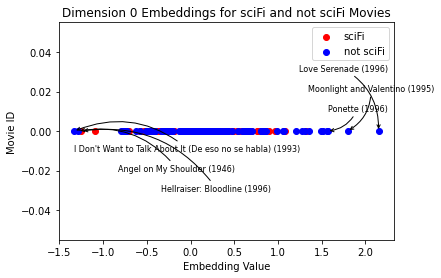

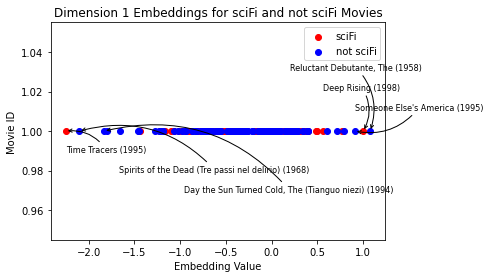

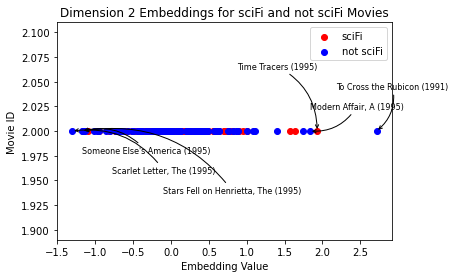

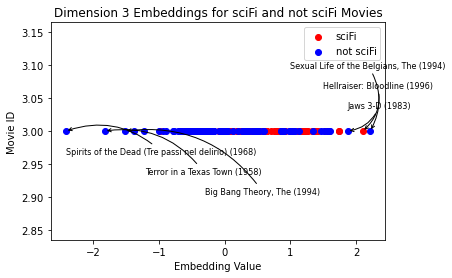

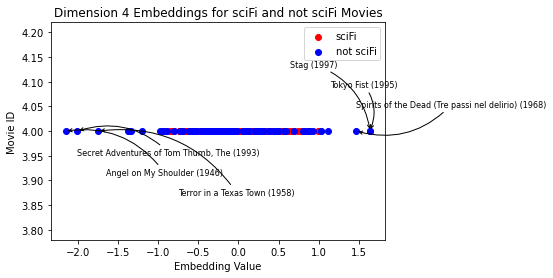

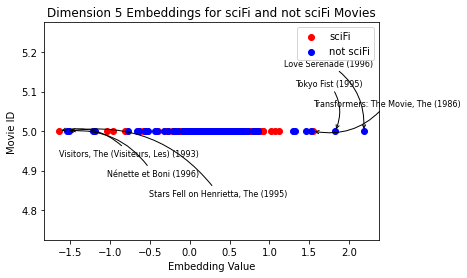

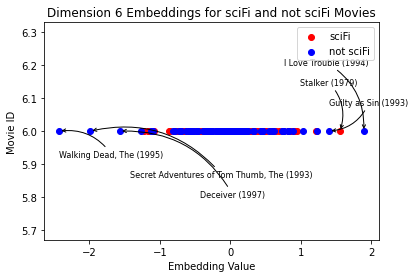

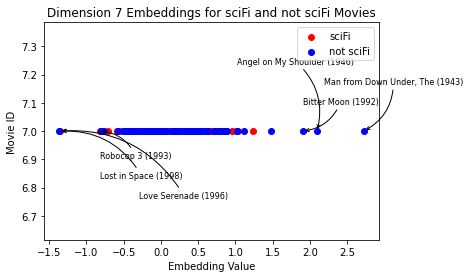

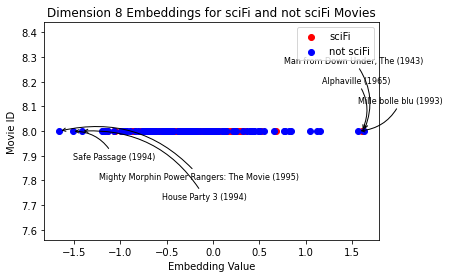

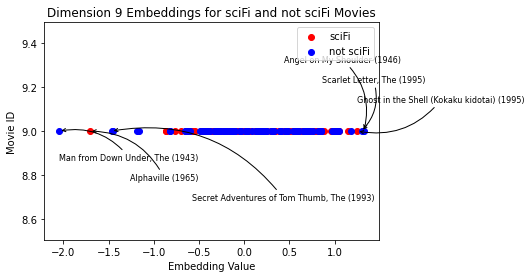

In [240]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')
plot_embs_one_genre(pmf.w_Item, moviesDF, 'sciFi', 100)

For SciFi, dimension 3 appears to be somewhat correlated, with sciFi movies having higher values in said dimension than non sciFi movies (or at least, what can be seen in the plot)

### (b)

In [250]:
def plot_embs_two_genres(embeddings, moviesDF, genres, sample_size):
  """
            INPUT:
                embeddings: numpy Array
                moviesDF: pandas DataFrame.
                          columns=['movieID',	'movieTitle',	'releaseDate	video','ReleaseDate',	'IMDbURL',...]
                genres: list of strings. (e.g., ['action', 'comedy'])
                sample_size: int


            OUTPUT:
                None

            NOTE: 1. You can read the file 'u.item' into a pandaas DataFrame for using as moviesDF
  """

  genre1 = genres[0]
  genre2 = genres[1]
  np.random.seed(3)
  genre1_movie_ids = np.random.choice(moviesDF[moviesDF[genre1] == 1]['movieID'].values, size = sample_size, replace=False)
  genre1_embeddings = embeddings[genre1_movie_ids]

  genre2_movie_ids = np.random.choice(moviesDF[moviesDF[genre2] == 1]['movieID'].values, size = sample_size, replace=False)
  genre2_embeddings = embeddings[genre2_movie_ids]

  all_ids = np.concatenate([genre1_movie_ids, genre2_movie_ids])
  index2id = {i:all_ids[i] for i in range(all_ids.shape[0])}

  all_embeddings = embeddings[all_ids]


  top_indices = np.argpartition(all_embeddings, -3, axis=0)[-3:]

  bottom_indices = np.argpartition(all_embeddings, 3, axis=0)[:3]

  v_offset = 20

  for i in range(embeddings.shape[1]):
    plt.close()
    plt.figure()
    plt.scatter(genre1_embeddings[:, i], np.full_like(genre1_movie_ids, i), c='red', label=f'{genre1}')
    plt.scatter(genre2_embeddings[:, i], np.full_like(genre2_movie_ids, i), c='blue', label=f'{genre2}')

    for k, j in enumerate(top_indices[:, i]):
      y_offset = k * v_offset
      plt.annotate(moviesDF.loc[moviesDF['movieID'] == index2id[j], 'movieTitle'].values[0], (all_embeddings[j, i], i ), xytext=(-2*y_offset, 20+i+y_offset), textcoords='offset points', fontsize=8, color='black', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.3' ,color='black'))

    for k, j in enumerate(bottom_indices[:, i]):
      y_offset = k * v_offset
      plt.annotate(moviesDF.loc[moviesDF['movieID'] == index2id[j], 'movieTitle'].values[0], (all_embeddings[j, i], i), xytext=(2*y_offset, -20-i-y_offset), textcoords='offset points', fontsize=8, color='black', arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=0.3', color='black'))

    plt.xlabel('Embedding Value')
    plt.ylabel('Movie ID')
    plt.legend()
    plt.title(f'Dimension {i} Embeddings for {genre1} and {genre2} Movies')
    plt.show()




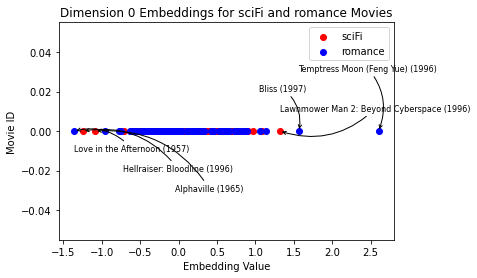

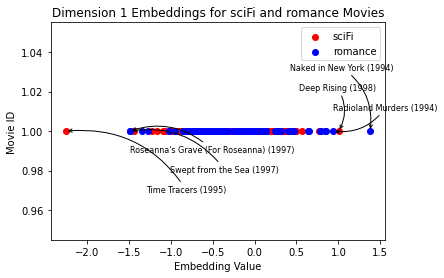

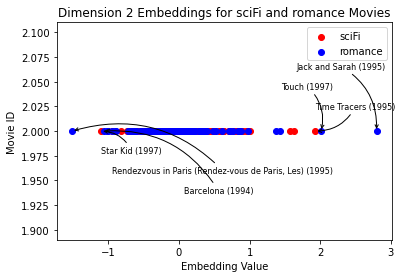

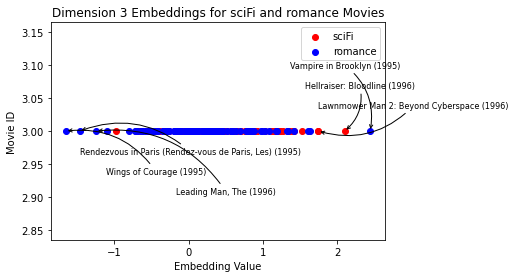

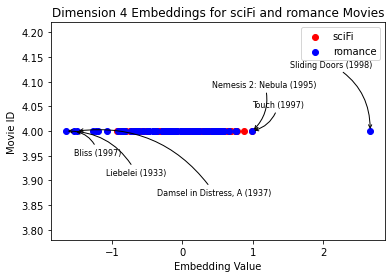

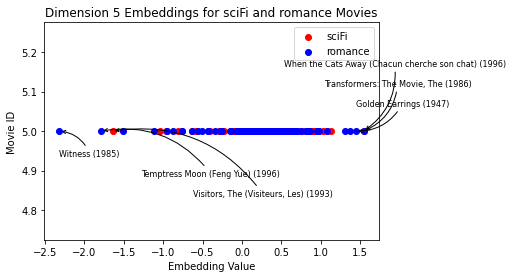

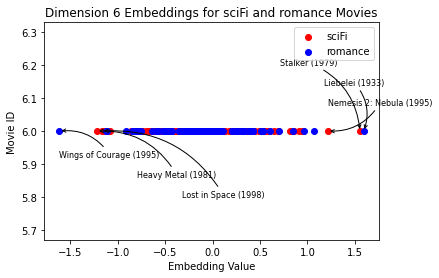

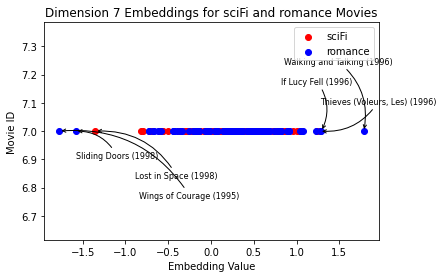

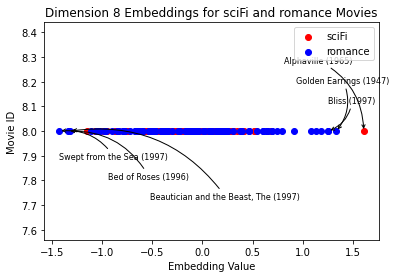

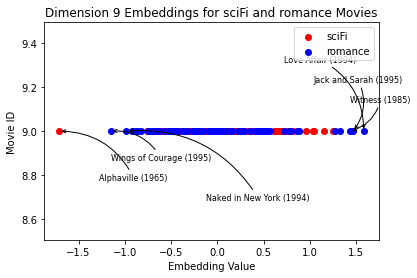

In [251]:
plot_embs_two_genres(pmf.w_Item, moviesDF, ['sciFi','romance'], 100)

No, I can't see a noticable difference between the two genres. Despite the two genres being very different from each other, I think many movie-goers enjoy movies from various genres, and therefore the features are not so evenly split by genre.

# Validation

In [252]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [253]:
def validateDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [254]:
validation_df = validateDataPreprocessor()

## Baseline Recommendation Systems

### Popularity Based Recommendation

In [255]:
def validatePopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [256]:
validatePopularityRecSys()

### User Average Based Recommendation

In [257]:
def validateUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    #useraverage_recsys = BaseLineRecSys('average_user_rating')
    useraverage_recsys = BaseLineRecSys('useraverage')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [258]:
validateUserAverRecSys()

## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [259]:
def validateEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)

In [260]:
validateEuclidean()

### Customized Similarity Function (test somethingelse function)

In [261]:
def validateCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)

In [262]:
validateCustomizedSim()

### User-User Similarity Based Recommendation System

In [263]:
def validateUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Framework error, please make sure you are using given yml file.")
        return

    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [264]:
validateUUSimBasedRecSys()

C:\Users\kirby\AppData\Local\Temp\ipykernel_17720\672937991.py:87: RuntimeWarning: invalid value encountered in true_divide
  useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)


### Item-Item Similarity Based Recommendation System

In [265]:
def validateIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Framework error, please make sure you are using given yml file.")
        return

    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [266]:
validateIISimBasedRecSys()

In [267]:
def validatePMFRecSys(validation_df=validation_df):
    try:
        pmf = PMFRecSys()
        pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 1, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})
        pmf.predict_all(rating_df, ROW_NUM, COL_NUM)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return

    try:
        pmf.predict_all(validation_df, ROW_NUM, COL_NUM)
        W_item, W_user = pmf.w_Item, pmf.w_User
        assert(W_item.shape == (COL_NUM+1, 10) and W_user.shape == (ROW_NUM+1, 10)),\
        "Shape of w_Item and W_User doesn't match predefined shape"
    except Exception as e:
        print(e)

In [268]:
validatePMFRecSys(validation_df=validation_df)